<hr>
<font size=5 color='#3E54D3'> <b> Brain Tumor Detection - K. Weigel </b> </font>
<hr/>

The objective of this project is to create a deep learning model that can classify an MRI image of the brain into two catagories: tumor, no tumor. We will be using [Brain Tumor Dataset](https://www.kaggle.com/navoneel/brain-mri-images-for-brain-tumor-detection) from Kaggle. The dataset consists of 253 images, out of which 155 belong to the no tumor class.

## 1 - Packages

In [ ]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import zipfile
import cv2
import imutils
import torch
import torch.nn as nn
import glob
import torch.optim as optim
import seaborn as sns
from torchsummary import summary
from torchvision import transforms, datasets, models
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from PIL import Image

In [ ]:
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


## 2 - Data preparation

In [ ]:
zip_ref = zipfile.ZipFile('/content/drive/My Drive/brain-tumor-detection/mri-images.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
images_path = '/content/brain_tumor_dataset/'
neg_images_path = '/content/brain_tumor_dataset/no/'
pos_images_path = '/content/brain_tumor_dataset/yes/'
neg_images_list = os.listdir(neg_images_path)
pos_images_list = os.listdir(pos_images_path)

print(f'Number of tumor cases: {len(pos_images_list)}, number of no tumor cases: {len(neg_images_list)}')
print('Total number of images: ', len(pos_images_list) + len(neg_images_list))

Number of tumor cases: 155, number of no tumor cases: 98
Total number of images:  253


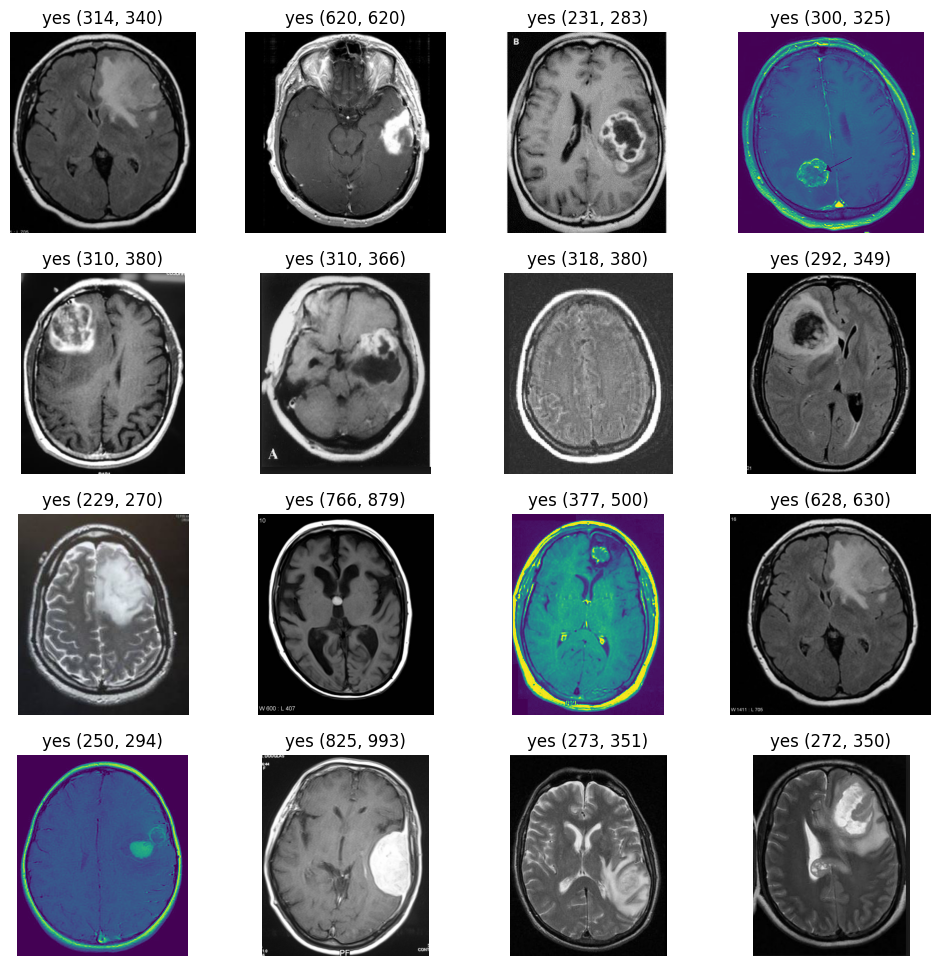

In [ ]:
fig = plt.figure(figsize=(12, 12))

for i in range(16):
    plt.subplot(4, 4, i+1)
    img = Image.open(os.path.join(pos_images_path, pos_images_list[i]))
    plt.title('yes ' + str(img.size))
    plt.imshow(img)
    plt.axis('off')

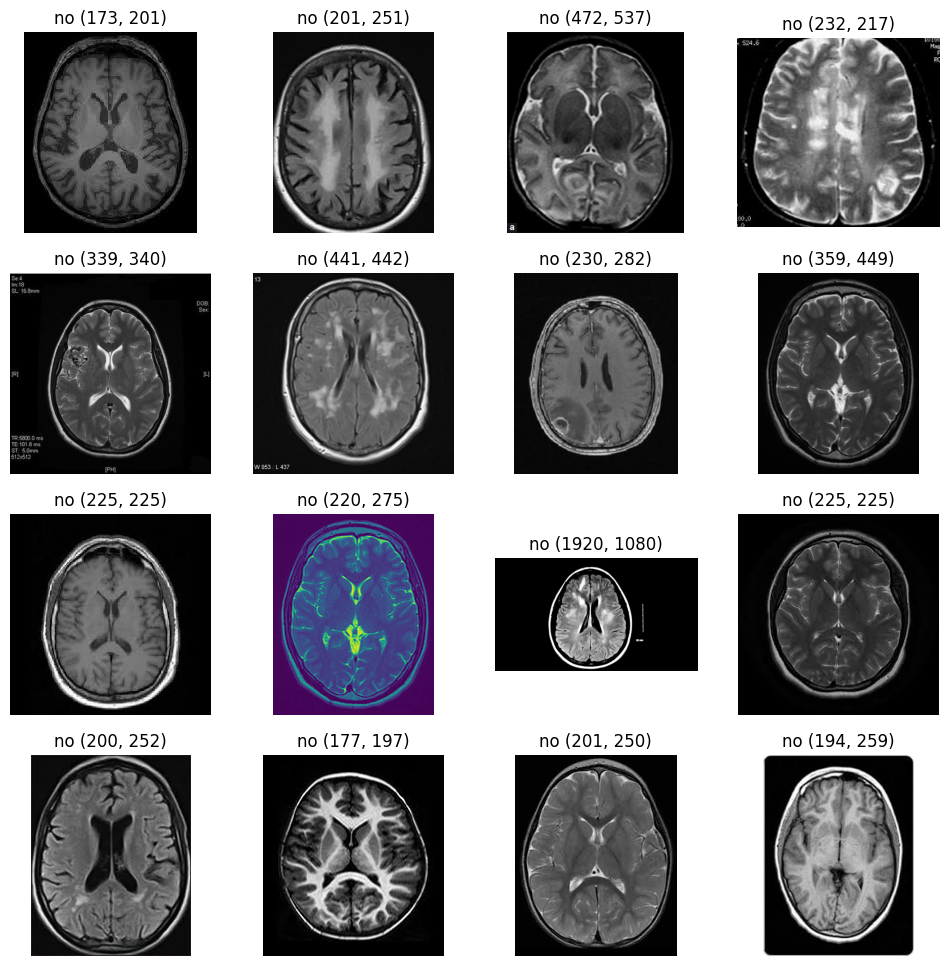

In [ ]:
fig = plt.figure(figsize=(12, 12))

for i in range(16):
    plt.subplot(4, 4, i+1)
    img = Image.open(os.path.join(neg_images_path, neg_images_list[i]))
    plt.title('no ' + str(img.size))
    plt.imshow(img)
    plt.axis('off')

We see that the images have different sizes, and some of them have a large background area. We will crop out the center part of the brain, and resize the images, so that they have the same spatial dimension. We will also use data augmentation to prevent our model from overfitting too much to the training data.

In [ ]:
# source: https://pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/

def contour_crop(image):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    return new_image

In [ ]:
class MRIDataset(Dataset):
    def __init__(self, dataset, transform):
        super().__init__()
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        image, label = self.dataset[index]
        if self.transform:
            image = self.transform(image)
        return image, label

In [ ]:
class MRIImageFolder(datasets.ImageFolder):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.class_folders = [f for f in sorted(os.listdir(root_dir)) if os.path.isdir(os.path.join(root_dir, f))]
        # print(self.class_folders)
        self.image_paths = []
        self.labels = []

        for label, class_folder in enumerate(self.class_folders):
            #class_imgs = os.listdir(os.path.join(root_dir, class_folder))
            #class_paths = os.path.join(root_dir, class_folder, class_imgs)
            img_paths = glob.glob(os.path.join(root_dir, class_folder, '*'))
            self.image_paths.extend(img_paths)
            self.labels.extend([label] * len(img_paths))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        # image = Image.open(img_path).convert('RGB')
        image = cv2.imread(img_path)
        image = contour_crop(image)

        return image, label

In [ ]:
transform_train = transforms.Compose([transforms.ToPILImage(),
                                      transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomAutocontrast(0.2),
                                      transforms.RandomAdjustSharpness(0.3),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

transform_val = transforms.Compose([transforms.ToPILImage(),
                                    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
                                    transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [ ]:
data = MRIImageFolder(images_path)

n_val = int(np.floor(0.2 * len(data)))
n_train = len(data) - n_val
train, val = random_split(data, [n_train, n_val])

train_ds = MRIDataset(train, transform_train)
val_ds = MRIDataset(val, transform_val)

print(len(data))
print(len(train_ds))
print(len(val_ds))

253
203
50


In [ ]:
BATCH_SIZE = 16
train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
def plot_data(generator):
    imgs, labels = next(generator)
    names = ['no', 'yes']
    # re-normalize the images for plotting
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    imgs = imgs * std[None, :, None, None] + mean[None, :, None, None]

    fig = plt.figure(figsize=(12, 6))

    for i in range(9):
        plt.subplot(3, 3, i+1)
        image = imgs[i].numpy()
        image = np.transpose(image, (1, 2, 0))
        plt.imshow((image * 255).astype(np.uint8))
        plt.title(names[int(labels[i])])
        #plt.title(labels[i])
        plt.axis('off')

    fig.tight_layout()

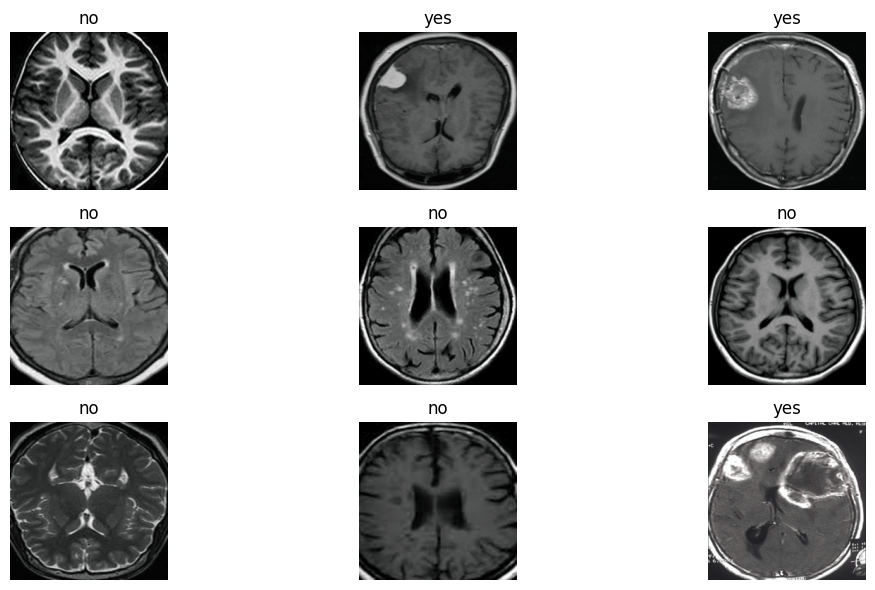

In [ ]:
plot_data(iter(train_dl))

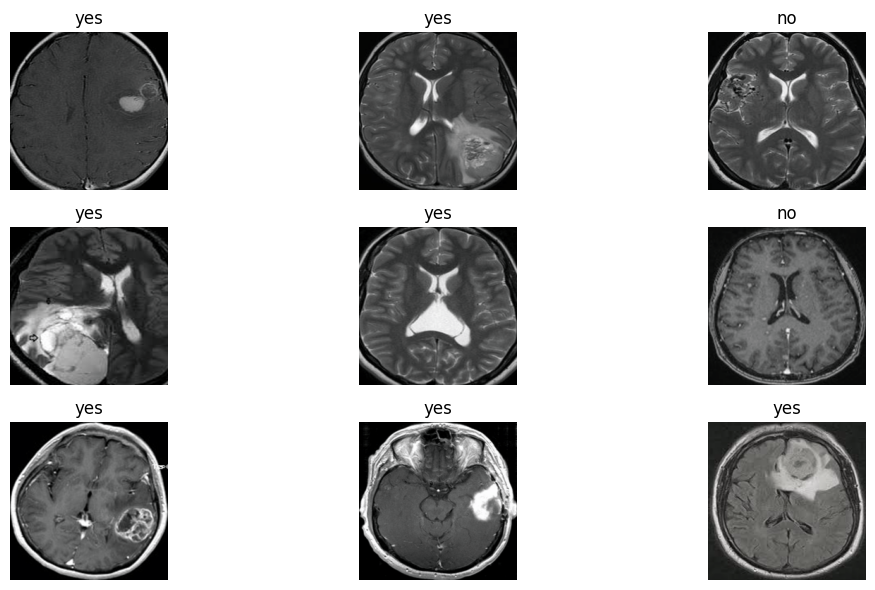

In [ ]:
plot_data(iter(val_dl))

## 3 - Convolutional Neural Network

In [ ]:
def check_accuracy(model, loader):
    """
    Check accuracy of the model.
    
    Inputs:
    - model: A PyTorch model
    - loader: A DataLoader object to evaluate the model on
    """
    num_correct = 0
    num_samples = 0
    acc = 0
    step_loss = []
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = nn.functional.cross_entropy(scores, y)
            step_loss.append(loss.item())
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples

    return acc, np.mean(step_loss)


def train_model(model, optimizer, epochs=1):
    """
    Train a model using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    hist = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    for e in range(epochs):
        step_loss = []
        num_correct = 0
        num_samples = 0
        for t, (x, y) in enumerate(train_dl):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            loss = nn.functional.cross_entropy(scores, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            step_loss.append(loss.item())
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)

        train_acc, train_loss = float(num_correct) / num_samples, np.mean(step_loss)
        val_acc, val_loss = check_accuracy(model, val_dl)
        hist['val_acc'].append(val_acc)
        hist['val_loss'].append(val_loss)
        hist['train_acc'].append(train_acc)
        hist['train_loss'].append(train_loss)
        print(f'Epoch {e+1}, train loss = {train_loss:.2f}, train acc = {train_acc:.2f},'
              f' val loss = {val_loss:.2f}, val acc = {val_acc:.2f}')

    return hist

In [ ]:
# Basic approach with nn.Sequential
model_cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding='same'), # input size 224 x 224 x 3
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)), # halve the input -> 112 x 112 x 32
    nn.Dropout(0.4),

    nn.Conv2d(32, 64, kernel_size=(3, 3), padding='same'),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=(2, 2)), # -> 56 x 56 x 64
    nn.Dropout(0.5),

    nn.Flatten(),
    nn.Linear(64 * 56 * 56, 2)
)

In [ ]:
summary(model_cnn.cuda(), (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
           Dropout-5         [-1, 32, 112, 112]               0
            Conv2d-6         [-1, 64, 112, 112]          18,496
       BatchNorm2d-7         [-1, 64, 112, 112]             128
              ReLU-8         [-1, 64, 112, 112]               0
         MaxPool2d-9           [-1, 64, 56, 56]               0
          Dropout-10           [-1, 64, 56, 56]               0
          Flatten-11               [-1, 200704]               0
           Linear-12                    [-1, 2]         401,410
Total params: 420,994
Trainable params: 420,994
Non-trainable params: 0
-------------------------------

In [ ]:
# loss_fn = nn.functional.binary_cross_entropy_with_logits
optimizer = optim.Adam(model_cnn.parameters(), lr=0.0001)
hist = train_model(model_cnn, optimizer, epochs=50)

Epoch 1, train loss = 5.37, train acc = 0.57, val loss = 1.30, val acc = 0.54
Epoch 2, train loss = 1.30, train acc = 0.70, val loss = 1.02, val acc = 0.58
Epoch 3, train loss = 0.96, train acc = 0.67, val loss = 0.63, val acc = 0.66
Epoch 4, train loss = 0.65, train acc = 0.74, val loss = 0.63, val acc = 0.74
Epoch 5, train loss = 0.61, train acc = 0.75, val loss = 0.76, val acc = 0.64
Epoch 6, train loss = 0.52, train acc = 0.78, val loss = 0.63, val acc = 0.70
Epoch 7, train loss = 0.48, train acc = 0.83, val loss = 0.55, val acc = 0.74
Epoch 8, train loss = 0.43, train acc = 0.84, val loss = 0.89, val acc = 0.70
Epoch 9, train loss = 0.43, train acc = 0.82, val loss = 1.10, val acc = 0.58
Epoch 10, train loss = 0.78, train acc = 0.73, val loss = 0.80, val acc = 0.68
Epoch 11, train loss = 0.67, train acc = 0.76, val loss = 1.00, val acc = 0.68
Epoch 12, train loss = 0.65, train acc = 0.76, val loss = 0.82, val acc = 0.64
Epoch 13, train loss = 0.42, train acc = 0.86, val loss = 0.5

In [ ]:
check_accuracy(model_cnn, val_dl)

(0.82, 0.453708715736866)

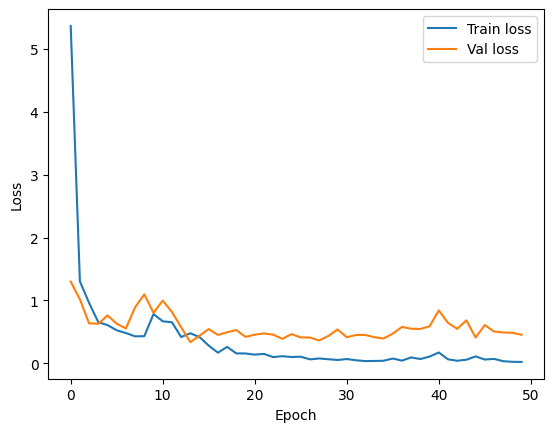

In [ ]:
plt.plot(hist['train_loss'], label='Train loss')
plt.plot(hist['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

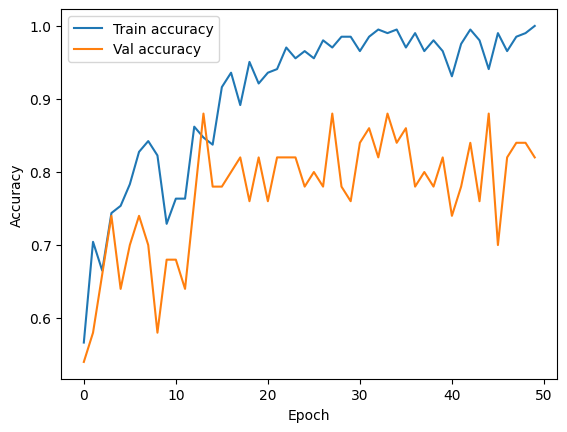

In [ ]:
plt.plot(hist['train_acc'], label='Train accuracy')
plt.plot(hist['val_acc'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
def get_metrics(model, loader, n_classes):
    """
    Compute a confusion matrix.
    
    Inputs:
    - model: A PyTorch model
    - loader: A DataLoader object to evaluate the model on
    - n_classes: Number of classes in the classification task
    """
    model.eval()
    confusion_matrix = np.zeros((n_classes, n_classes))
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)

            for t, p in zip(y.cpu().numpy(), preds.cpu().numpy()):
                confusion_matrix[t, p] += 1

    return confusion_matrix


def print_metrics(cm):
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]

    recall = tp / (tp + fn)
    precision = tp / (tp + fp)

    print('-- Precision : ', precision)
    print('-- Recall : ', recall)
    print('-- F1 : ', (2 * recall * precision) / (recall + precision))

In [ ]:
cm = get_metrics(model_cnn, val_dl, 2)

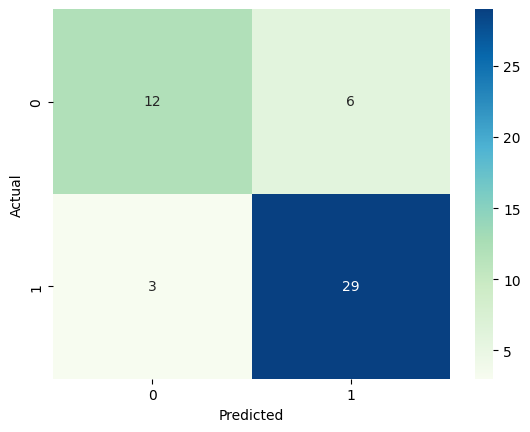

In [ ]:
sns.heatmap(cm, annot=True, cmap='GnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print_metrics(cm)

-- Precision :  0.8285714285714286
-- Recall :  0.90625
-- F1 :  0.8656716417910447


## Transfer learning with VGG16

VGG16 refers to the VGG model, also called VGGNet. It is a convolutional neural network (CNN) model supporting 16 layers. K. Simonyan and A. Zisserman from Oxford University proposed this model and published it in a paper called [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556).

In [ ]:
model_vgg = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
for param in model_vgg.parameters():
    param.requires_grad = False

model_vgg.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))

model_vgg.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(512, 128),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(128, 2)
)

optimizer = optim.Adam(model_vgg.parameters())
hist = train_model(model_vgg, optimizer, epochs=30)

Epoch 1, train loss = 0.65, train acc = 0.60, val loss = 0.56, val acc = 0.68
Epoch 2, train loss = 0.56, train acc = 0.73, val loss = 0.48, val acc = 0.68
Epoch 3, train loss = 0.50, train acc = 0.80, val loss = 0.42, val acc = 0.74
Epoch 4, train loss = 0.43, train acc = 0.83, val loss = 0.40, val acc = 0.76
Epoch 5, train loss = 0.40, train acc = 0.82, val loss = 0.36, val acc = 0.82
Epoch 6, train loss = 0.36, train acc = 0.89, val loss = 0.32, val acc = 0.78
Epoch 7, train loss = 0.35, train acc = 0.87, val loss = 0.30, val acc = 0.82
Epoch 8, train loss = 0.31, train acc = 0.91, val loss = 0.29, val acc = 0.84
Epoch 9, train loss = 0.29, train acc = 0.91, val loss = 0.26, val acc = 0.90
Epoch 10, train loss = 0.30, train acc = 0.90, val loss = 0.25, val acc = 0.88
Epoch 11, train loss = 0.27, train acc = 0.91, val loss = 0.26, val acc = 0.88
Epoch 12, train loss = 0.27, train acc = 0.90, val loss = 0.25, val acc = 0.86
Epoch 13, train loss = 0.24, train acc = 0.93, val loss = 0.2

In [ ]:
check_accuracy(model_vgg, val_dl)

(0.92, 0.1419813809916377)

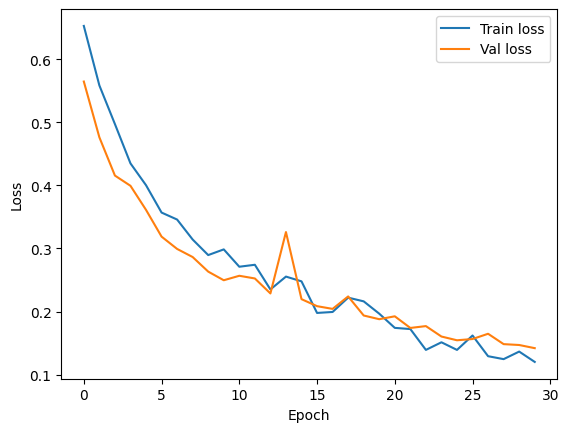

In [ ]:
plt.plot(hist['train_loss'], label='Train loss')
plt.plot(hist['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

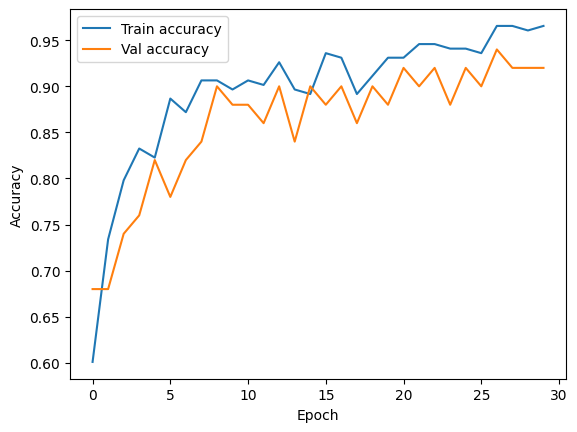

In [ ]:
plt.plot(hist['train_acc'], label='Train accuracy')
plt.plot(hist['val_acc'], label='Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
cm = get_metrics(model_vgg, val_dl, 2)

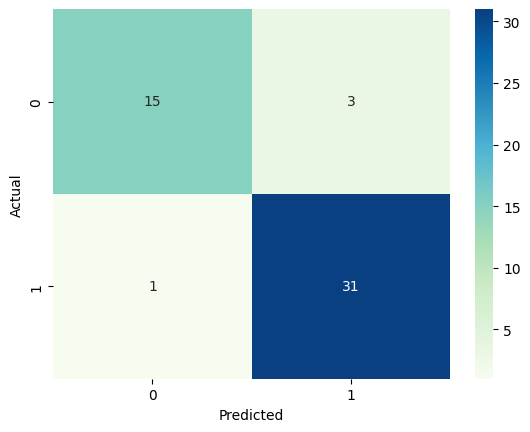

In [ ]:
sns.heatmap(cm, annot=True, cmap='GnBu')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
print_metrics(cm)

-- Precision :  0.9117647058823529
-- Recall :  0.96875
-- F1 :  0.9393939393939394
